# Layout_recogniton_notebook

# 📚 **Table of Contents**

### **🔹 Main Sections**
- [📸 **Pdf_to_image**](#pdf_to_image) : Converts PDFs to images  
- [🖼 **Image_normalization**](#Image_normalization) : Normalizes images  
- [✍️ **Annotation_tool**](#annotation_tool) : Tool for annotating images  

### **🔹 Data Processing**
- [🧹 **Data_preprocessing**](#data_preprocessing) : Prepares data for model training  

### **🔹 Model Development**
- [🧑‍💻 **Models**](#models) : Model architectures  
- [📊 **Training**](#training) : Training the models  
- [✅ **Evaluation**](#evaluation) : Evaluates model performance  

### **🔹 Results**
- [📊 **Evaluated_results**](#Evaluated_results) : Displays evaluation results  
- [🔮 **Prediction**](#Prediction) : Makes predictions using the model  

### **🔹 Testing**
- [🔄 **Random_data_testing**](#random_data) : Tests the model with random data  


# pdf_to_image
Converts all PDFs from data/raw into data/processed/images


In [ ]:
import os
import fitz  # PyMuPDF
import numpy as np
from PIL import Image

def convert_pdfs_to_images(pdf_dir, output_dir, dpi=300):
    os.makedirs(output_dir, exist_ok=True)
    
    for pdf_file in os.listdir(pdf_dir):
        if not pdf_file.endswith('.pdf'):
            continue
            
        pdf_path = os.path.join(pdf_dir, pdf_file)
        doc_name = os.path.splitext(pdf_file)[0]
        doc_output_dir = os.path.join(output_dir, doc_name)
        os.makedirs(doc_output_dir, exist_ok=True)
        
        doc = fitz.open(pdf_path)
        for page_num, page in enumerate(doc):
            pix = page.get_pixmap(matrix=fitz.Matrix(dpi/72, dpi/72))
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            img_path = os.path.join(doc_output_dir, f"{page_num+1:03d}.jpg")
            img.save(img_path, "JPEG", quality=95)
            
        print(f"Converted {pdf_file} - {len(doc)} pages")

if __name__ == "__main__":
    convert_pdfs_to_images("data/raw", "data/processed/images")


# Image_normalization
#Converts all images into same resolution (512x512) in this case


In [ ]:
import os
import cv2
import numpy as np

def create_pyramid(image_path, output_size=(512, 512)):
    """
    Reduce image resolution and save the resized image
    
    """
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Failed to load image: {image_path}")
            return f"Failed to load image: {image_path}"
        
        #Resize image
        resized = cv2.resize(img, output_size, interpolation=cv2.INTER_AREA)
        
        #Overwrite the original image
        cv2.imwrite(image_path, resized)
        
        return f"Processed: {image_path}"
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return f"Error processing {image_path}: {e}"

def process_images_in_directory(base_dir):
    """
    Process all images in subfolders of the given base directory

    """
    image_extensions = ['.jpg', '.jpeg', '.png', '.tif', '.tiff', '.bmp']
    processed_count = 0
    error_count = 0

    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                full_path = os.path.join(root, file)
                
                result = create_pyramid(full_path)

                if "Processed:" in result:
                    processed_count += 1
                else:
                    error_count += 1
                
                print(result)
    
    print(f"\nProcessing complete:")
    print(f"Total images processed: {processed_count}")
    print(f"Total errors: {error_count}")

base_dir = 'data/processed/images'

process_images_in_directory(base_dir)


Processed: data/processed/images\Buendia - Instruccion\001.jpg
Processed: data/processed/images\Buendia - Instruccion\002.jpg
Processed: data/processed/images\Buendia - Instruccion\003.jpg
Processed: data/processed/images\Buendia - Instruccion\004.jpg
Processed: data/processed/images\Buendia - Instruccion\005.jpg
Processed: data/processed/images\Buendia - Instruccion\006.jpg
Processed: data/processed/images\Constituciones sinodales Calahorra 1602\001.jpg
Processed: data/processed/images\Constituciones sinodales Calahorra 1602\002.jpg
Processed: data/processed/images\Constituciones sinodales Calahorra 1602\003.jpg
Processed: data/processed/images\Constituciones sinodales Calahorra 1602\004.jpg
Processed: data/processed/images\Constituciones sinodales Calahorra 1602\005.jpg
Processed: data/processed/images\Constituciones sinodales Calahorra 1602\006.jpg
Processed: data/processed/images\Ezcaray - Vozes\001.jpg
Processed: data/processed/images\Ezcaray - Vozes\002.jpg
Processed: data/proces

# annotation_tool
annotations in json format for model to learn from

In [ ]:
import os
import json
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
Image.MAX_IMAGE_PIXELS = None


class AnnotationTool:
    def __init__(self, root, image_dir, annotation_dir):
        self.root = root
        self.root.title("Layout Annotation Tool")
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        os.makedirs(annotation_dir, exist_ok=True)
        self.image_paths = []
        self.get_image_paths(image_dir)
        self.current_image_idx = 0

        self.setup_ui()

        if self.image_paths:
            self.load_image(self.image_paths[0])
        
    def get_image_paths(self, directory):
        for root, _, files in os.walk(directory):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(os.path.join(root, file))
    
    def setup_ui(self):
        frame = tk.Frame(self.root)
        frame.pack(fill=tk.BOTH, expand=True)
        self.canvas = tk.Canvas(frame, bg='white')
        self.canvas.pack(fill=tk.BOTH, expand=True)
        btn_frame = tk.Frame(self.root)
        btn_frame.pack(fill=tk.X)
 
        prev_btn = tk.Button(btn_frame, text="Previous", command=self.prev_image)
        prev_btn.pack(side=tk.LEFT, padx=5, pady=5)
        
        next_btn = tk.Button(btn_frame, text="Next", command=self.next_image)
        next_btn.pack(side=tk.LEFT, padx=5, pady=5)
        
        save_btn = tk.Button(btn_frame, text="Save", command=self.save_annotation)
        save_btn.pack(side=tk.LEFT, padx=5, pady=5)
        
        #Drawing mode
        self.drawing = False
        self.start_x = 0
        self.start_y = 0
        self.rectangle = None
        self.boxes = []
        
        #Canvas events
        self.canvas.bind("<ButtonPress-1>", self.on_mouse_down)
        self.canvas.bind("<B1-Motion>", self.on_mouse_move)
        self.canvas.bind("<ButtonRelease-1>", self.on_mouse_up)
    
    def load_image(self, path):
        self.current_image_path = path
        image = Image.open(path)

        max_size = 800
        if image.width > max_size or image.height > max_size:
            ratio = min(max_size / image.width, max_size / image.height)
            new_size = (int(image.width * ratio), int(image.height * ratio))
            image = image.resize(new_size, Image.LANCZOS)
        
        self.tk_image = ImageTk.PhotoImage(image)
        self.canvas.config(width=self.tk_image.width(), height=self.tk_image.height())
        self.canvas.create_image(0, 0, anchor=tk.NW, image=self.tk_image)

        self.boxes = []

        rel_path = os.path.relpath(path, self.image_dir)
        doc_name = os.path.dirname(rel_path)
        file_name = os.path.splitext(os.path.basename(rel_path))[0]
        
        annotation_doc_dir = os.path.join(self.annotation_dir, doc_name)
        os.makedirs(annotation_doc_dir, exist_ok=True)
        
        annotation_path = os.path.join(annotation_doc_dir, f"{file_name}.json")
        
        if os.path.exists(annotation_path):
            with open(annotation_path, 'r') as f:
                data = json.load(f)
                self.boxes = data.get('text_regions', [])

            for box in self.boxes:
                self.canvas.create_rectangle(box[0], box[1], box[2], box[3], outline='red', width=2)
    
    def on_mouse_down(self, event):
        self.drawing = True
        self.start_x = self.canvas.canvasx(event.x)
        self.start_y = self.canvas.canvasy(event.y)
        self.rectangle = self.canvas.create_rectangle(
            self.start_x, self.start_y, self.start_x, self.start_y,
            outline='red', width=2
        )
    
    def on_mouse_move(self, event):
        if self.drawing:
            cur_x = self.canvas.canvasx(event.x)
            cur_y = self.canvas.canvasy(event.y)
            self.canvas.coords(self.rectangle, self.start_x, self.start_y, cur_x, cur_y)
    
    def on_mouse_up(self, event):
        if self.drawing:
            self.drawing = False
            end_x = self.canvas.canvasx(event.x)
            end_y = self.canvas.canvasy(event.y)

            x1 = min(self.start_x, end_x)
            y1 = min(self.start_y, end_y)
            x2 = max(self.start_x, end_x)
            y2 = max(self.start_y, end_y)

            self.boxes.append([int(x1), int(y1), int(x2), int(y2)])
    
    def save_annotation(self):
        rel_path = os.path.relpath(self.current_image_path, self.image_dir)
        doc_name = os.path.dirname(rel_path)
        file_name = os.path.splitext(os.path.basename(rel_path))[0]
        
        annotation_doc_dir = os.path.join(self.annotation_dir, doc_name)
        os.makedirs(annotation_doc_dir, exist_ok=True)
        
        annotation_path = os.path.join(annotation_doc_dir, f"{file_name}.json")
        
        data = {"text_regions": self.boxes}
        
        with open(annotation_path, 'w') as f:
            json.dump(data, f, indent=4)
            
        print(f"Saved annotations to {annotation_path}")
    
    def next_image(self):
        if self.current_image_idx < len(self.image_paths) - 1:
            self.current_image_idx += 1
            self.load_image(self.image_paths[self.current_image_idx])
    
    def prev_image(self):
        if self.current_image_idx > 0:
            self.current_image_idx -= 1
            self.load_image(self.image_paths[self.current_image_idx])

if __name__ == "__main__":
    root = tk.Tk()
    app = AnnotationTool(root, r"data\processed\images", r"data\processed\annotations")
    root.mainloop()


# data_preprocessing
This step creates masks using annoted json files

Preparing data from:
  Images: data\processed\images
  Annotations: data\processed\annotations
  Output: data\prepared
Found source folders: ['Buendia - Instruccion', 'Constituciones sinodales Calahorra 1602', 'Ezcaray - Vozes', 'Mendo - Principe perfecto', 'Paredes - Reglas generales', 'PORCONES.228.35 - 1636', 'PORCONES.228.35 – 1636']
Processing source: Buendia - Instruccion
  Image folder: data\processed\images\Buendia - Instruccion
  Annotation folder: data\processed\annotations\Buendia - Instruccion
  Found 6 image files
  Processed 6 images from Buendia - Instruccion
Processing source: Constituciones sinodales Calahorra 1602
  Image folder: data\processed\images\Constituciones sinodales Calahorra 1602
  Annotation folder: data\processed\annotations\Constituciones sinodales Calahorra 1602
  Found 6 image files
  Processed 6 images from Constituciones sinodales Calahorra 1602
Processing source: Ezcaray - Vozes
  Image folder: data\processed\images\Ezcaray - Vozes
  Annotation fold

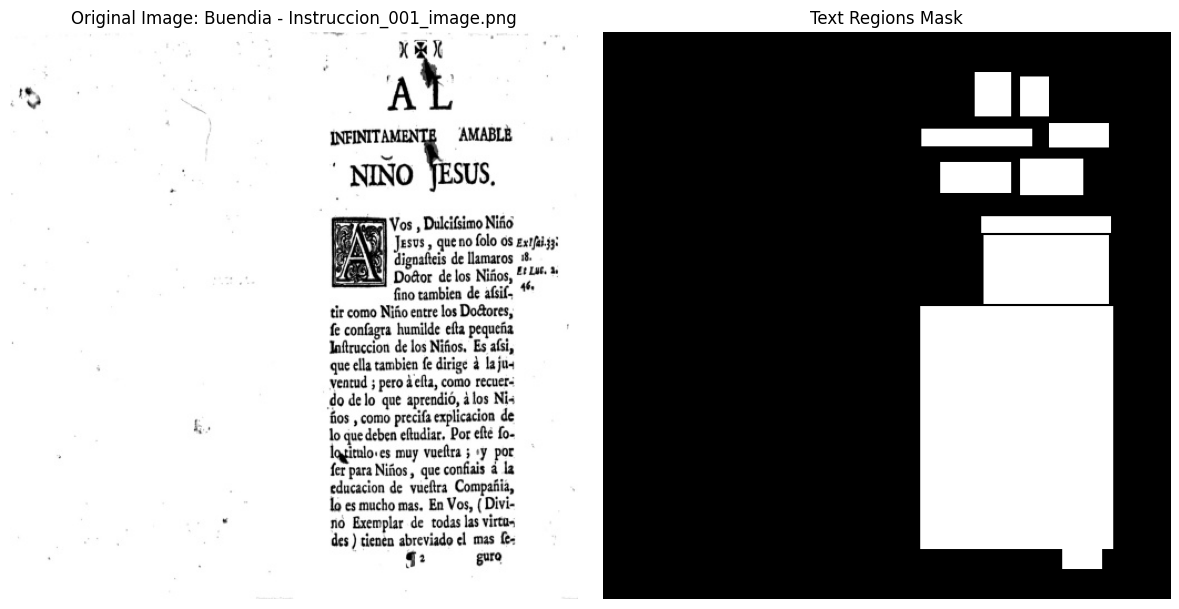

In [ ]:


import os
import json
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def load_annotation(annotation_path):
    try:
        with open(annotation_path, 'r') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error loading annotation {annotation_path}: {e}")
        return None

def load_image(image_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Cannot load image at {image_path}")
        return image
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def create_mask_from_regions(image_shape, text_regions):
    """
    Create a binary mask from text regions.
    
    """
    height, width = image_shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)
    
    # Debug information
    print(f"Image dimensions: {width}x{height}")
    print(f"Text regions: {text_regions}")
    
    if text_regions and isinstance(text_regions, list):
        for i, region in enumerate(text_regions):
            if len(region) == 4:  # Ensure region has 4 coordinates
                x1, y1, x2, y2 = region
                
                # Debug
                print(f"Region {i}: original coordinates [{x1}, {y1}, {x2}, {y2}]")
                x1 = max(0, min(x1, width-1))
                y1 = max(0, min(y1, height-1))
                x2 = max(0, min(x2, width))
                y2 = max(0, min(y2, height))
                
                print(f"Region {i}: adjusted coordinates [{x1}, {y1}, {x2}, {y2}]")
                
                cv2.rectangle(mask, (x1, y1), (x2, y2), 255, -1)  # -1 means filled rectangle
            else:
                print(f"Warning: Invalid region format: {region}")
    else:
        print(f"Warning: Invalid text_regions: {text_regions}")
    
    nonzero = np.count_nonzero(mask)
    print(f"Mask has {nonzero} non-zero pixels out of {height*width} ({nonzero/(height*width)*100:.2f}%)")
        
    return mask

def prepare_data(images_dir, annotations_dir, output_dir, image_size=(512, 512)):
    """
    Prepare data for layout recognition training.
    
    """
    print(f"Preparing data from:")
    print(f"  Images: {images_dir}")
    print(f"  Annotations: {annotations_dir}")
    print(f"  Output: {output_dir}")
    
    os.makedirs(output_dir, exist_ok=True)
    
    if not os.path.exists(images_dir):
        print(f"Error: Images directory does not exist: {images_dir}")
        return []
        
    if not os.path.exists(annotations_dir):
        print(f"Error: Annotations directory does not exist: {annotations_dir}")
        return []
    
    source_folders = [f for f in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, f))]
    
    if not source_folders:
        print(f"Warning: No source folders found in {images_dir}")
        return []
        
    print(f"Found source folders: {source_folders}")
    data_items = []
    
    for source_folder in source_folders:
        image_folder = os.path.join(images_dir, source_folder)
        annotation_folder = os.path.join(annotations_dir, source_folder)
        
        print(f"Processing source: {source_folder}")
        print(f"  Image folder: {image_folder}")
        print(f"  Annotation folder: {annotation_folder}")
        
        if not os.path.isdir(image_folder):
            print(f"Warning: Image folder does not exist: {image_folder}")
            continue
            
        if not os.path.isdir(annotation_folder):
            print(f"Warning: Annotation folder does not exist: {annotation_folder}")
            continue
        
    
        image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        if not image_files:
            print(f"Warning: No image files found in {image_folder}")
            continue
            
        print(f"  Found {len(image_files)} image files")
        processed_count = 0
        
        for image_file in image_files:
            annotation_file = os.path.splitext(image_file)[0] + '.json'
            annotation_path = os.path.join(annotation_folder, annotation_file)
            
            if not os.path.exists(annotation_path):
                print(f"Warning: No annotation found for {image_file}")
                continue
            
            image_path = os.path.join(image_folder, image_file)
            
            image = load_image(image_path)
            if image is None:
                continue
                
            annotation = load_annotation(annotation_path)
            if annotation is None:
                continue
            
            if 'text_regions' not in annotation:
                print(f"Warning: No text_regions in annotation {annotation_path}")
                continue
            original_height, original_width = image.shape[:2]
        
            scale_x = image_size[0] / original_width
            scale_y = image_size[1] / original_height
            scaled_regions = []
            for region in annotation['text_regions']:
                if len(region) == 4:
                    x1, y1, x2, y2 = region
                    scaled_regions.append([
                        int(x1 * scale_x),
                        int(y1 * scale_y),
                        int(x2 * scale_x),
                        int(y2 * scale_y)
                    ])
            
            image_resized = cv2.resize(image, image_size)
            
            mask_resized = np.zeros((image_size[1], image_size[0]), dtype=np.uint8)
            
            for region in scaled_regions:
                x1, y1, x2, y2 = region
                x1 = max(0, min(x1, image_size[0]-1))
                y1 = max(0, min(y1, image_size[1]-1))
                x2 = max(0, min(x2, image_size[0]))
                y2 = max(0, min(y2, image_size[1]))
                
                cv2.rectangle(mask_resized, (x1, y1), (x2, y2), 255, -1)
            output_base = f"{source_folder}_{os.path.splitext(image_file)[0]}"
            output_image_path = os.path.join(output_dir, f"{output_base}_image.png")
            output_mask_path = os.path.join(output_dir, f"{output_base}_mask.png")
            
            cv2.imwrite(output_image_path, image_resized)
            cv2.imwrite(output_mask_path, mask_resized)
            
            data_items.append({
                'image_path': output_image_path,
                'mask_path': output_mask_path,
                'source': source_folder,
                'original_image': image_path,
                'original_annotation': annotation_path
            })
            
            processed_count += 1
            
        print(f"  Processed {processed_count} images from {source_folder}")
    
    print(f"Total processed data items: {len(data_items)}")
    return data_items

def split_dataset(data_items, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42):
    """
    Split dataset into training, validation, and test sets.
    
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-10, "Ratios must sum to 1"
    
    if not data_items:
        print("Warning: No data items to split")
        return [], [], []
    
    train_val, test = train_test_split(data_items, test_size=test_ratio, random_state=random_state)
    train, val = train_test_split(train_val, test_size=val_ratio/(train_ratio+val_ratio), random_state=random_state)
    
    return train, val, test

def visualize_sample(data_item):
    """
    Visualize a sample (image and mask).
    data_item : Data item containing image and mask paths.
    """
    if not data_item:
        print("Error: No data item to visualize")
        return
        
    if 'image_path' not in data_item or 'mask_path' not in data_item:
        print("Error: Data item missing image_path or mask_path")
        return
        
    if not os.path.exists(data_item['image_path']):
        print(f"Error: Image file not found: {data_item['image_path']}")
        return
        
    if not os.path.exists(data_item['mask_path']):
        print(f"Error: Mask file not found: {data_item['mask_path']}")
        return
    
    try:
        image = cv2.imread(data_item['image_path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(data_item['mask_path'], cv2.IMREAD_GRAYSCALE)
        
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"Original Image: {os.path.basename(data_item['image_path'])}")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Text Regions Mask')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error visualizing sample: {e}")

def main():
    data_dir = os.path.join('data', 'processed', 'images')
    annotations_dir = os.path.join('data', 'processed', 'annotations')
    output_dir = os.path.join('data', 'prepared')

    data_items = prepare_data(data_dir, annotations_dir, output_dir)
    train_data, val_data, test_data = split_dataset(data_items)
    
    splits = {
        'train': [item['image_path'] for item in train_data],
        'val': [item['image_path'] for item in val_data],
        'test': [item['image_path'] for item in test_data]
    }
    
    with open(os.path.join(output_dir, 'splits.json'), 'w') as f:
        json.dump(splits, f)
    
    print(f"Prepared {len(data_items)} samples")
    print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")
    
    if data_items:
        visualize_sample(data_items[0])
    else:
        print("No data items to visualize")

if __name__ == "__main__":
    main()

# models
algorithms like unet, resnet-unet and cnn-rnn hybrid is iniatialised

In [ ]:


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class ConvBlock(nn.Module):
    """
    Convolutional block with batch normalization and ReLU activation.
    """
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        #self.dropout = nn.Dropout(p=dropout_rate)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        #x = self.dropout(x)
        return x

class EncoderBlock(nn.Module):
    """
    Encoder block for U-Net.
    """
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv1 = ConvBlock(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        features = self.conv1(x)
        features = self.conv2(features)
        pooled = self.pool(features)
        return pooled, features

class DecoderBlock(nn.Module):
    """
    Decoder block for U-Net.
    """
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = ConvBlock(out_channels + skip_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)
    
    def forward(self, x, skip):
        x = self.upconv(x)
        
        diff_h = skip.size()[2] - x.size()[2]
        diff_w = skip.size()[3] - x.size()[3]
        
        x = F.pad(x, [diff_w // 2, diff_w - diff_w // 2, diff_h // 2, diff_h - diff_h // 2])
        
        x = torch.cat([skip, x], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(nn.Module):
    """
    U-Net model for layout recognition.
    """
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        self.enc1 = EncoderBlock(in_channels, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)
        
        self.bottleneck = nn.Sequential(
            ConvBlock(512, 1024),
            ConvBlock(1024, 1024)
        )
        
        self.dec4 = DecoderBlock(1024, 512, 512)
        self.dec3 = DecoderBlock(512, 256, 256)
        self.dec2 = DecoderBlock(256, 128, 128)
        self.dec1 = DecoderBlock(128, 64, 64)
        
        self.output = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        x, skip1 = self.enc1(x)
        x, skip2 = self.enc2(x)
        x, skip3 = self.enc3(x)
        x, skip4 = self.enc4(x)
        ###
        x = self.bottleneck(x)
        ###
        x = self.dec4(x, skip4)
        x = self.dec3(x, skip3)
        x = self.dec2(x, skip2)
        x = self.dec1(x, skip1)
        
        x = self.output(x)
        return torch.sigmoid(x)

class ResNetUNet(nn.Module):
    """
    U-Net model with ResNet backbone for layout recognition.
    """
    def __init__(self, in_channels=3, out_channels=1, pretrained=True):
        super(ResNetUNet, self).__init__()
        
        self.encoder = models.resnet34(weights='IMAGENET1K_V1' if pretrained else None)
        
        self.enc1 = nn.Sequential(
            self.encoder.conv1,
            self.encoder.bn1,
            self.encoder.relu
        )
        self.pool = self.encoder.maxpool
        self.enc2 = self.encoder.layer1
        self.enc3 = self.encoder.layer2
        self.enc4 = self.encoder.layer3
        self.enc5 = self.encoder.layer4
        #########
        self.dec5 = DecoderBlock(512, 256, 256) 
        self.dec4 = DecoderBlock(256, 128, 128)
        self.dec3 = DecoderBlock(128, 64, 64)
        self.dec2 = DecoderBlock(64, 64, 64)
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            ConvBlock(32, 32),
            nn.Conv2d(32, out_channels, kernel_size=1)
        )
    
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.pool(enc1)
        enc2 = self.enc2(enc2)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)
        
        dec5 = self.dec5(enc5, enc4)
        dec4 = self.dec4(dec5, enc3)
        dec3 = self.dec3(dec4, enc2)
        dec2 = self.dec2(dec3, enc1)
        dec1 = self.dec1(dec2)
        
        return torch.sigmoid(dec1)
    
class CNN_RNN_Model(nn.Module):
    """
    CNN-RNN model for layout recognition and segmentation.
    Combines ResNet features with LSTM for sequential processing,
    then upsamples to create full-resolution segmentation maps.
    """
    def __init__(self, in_channels=3, out_channels=1, pretrained=True, hidden_size=256, num_layers=2):
        super(CNN_RNN_Model, self).__init__()
        
        resnet = models.resnet34(weights='IMAGENET1K_V1' if pretrained else None)
        
        self.enc1 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu
        )
        self.pool = resnet.maxpool  
        self.enc2 = resnet.layer1
        self.enc3 = resnet.layer2
        self.enc4 = resnet.layer3
        self.enc5 = resnet.layer4
        
        self.lstm_hidden_size = hidden_size
        self.lstm = nn.LSTM(512, hidden_size, num_layers, batch_first=True)
        
        self.lstm_proj = nn.Conv2d(hidden_size, 512, kernel_size=1)
        
        self.dec5 = DecoderBlock(512, 256, 256)
        self.dec4 = DecoderBlock(256, 128, 128)
        self.dec3 = DecoderBlock(128, 64, 64)
        self.dec2 = DecoderBlock(64, 64, 64)
        
        self.final_upsampling = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)
    
    def forward(self, x):
        input_size = x.size()
        batch_size = input_size[0]
        
        enc1 = self.enc1(x)
        enc2 = self.pool(enc1)
        enc2 = self.enc2(enc2)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)         # 1/32 resolution
        
        feature_h, feature_w = enc5.size(2), enc5.size(3)
        features_seq = enc5.view(batch_size, 512, -1).permute(0, 2, 1)
        
        #Run LSTM
        lstm_out, _ = self.lstm(features_seq)
        
        #Reshape back to feature map format
        lstm_out = lstm_out.permute(0, 2, 1).view(batch_size, self.lstm_hidden_size, feature_h, feature_w)
        
        dec_features = self.lstm_proj(lstm_out)
        
        x = self.dec5(dec_features, enc4)
        x = self.dec4(x, enc3)
        x = self.dec3(x, enc2)
        x = self.dec2(x, enc1)
        
        x = self.final_upsampling(x)
        x = self.final_conv(x)
        
        return torch.sigmoid(x)

def get_model(model_name='CNN_RNN_Model', in_channels=3, out_channels=1, pretrained=True):
    """
    Get model by name.
    
    """
    if model_name.lower() == 'unet':
        return UNet(in_channels, out_channels)
    elif model_name.lower() == 'resnet_unet':
        return ResNetUNet(in_channels, out_channels, pretrained)
    elif model_name.lower() == 'cnn_rnn_model':
        return CNN_RNN_Model(in_channels, out_channels, pretrained)
    else:
        raise ValueError(f"Model {model_name} not supported. Choose from 'unet', 'resnet_unet', 'cnn_rnn_model.")



# training
now we train our model with data in data/prepared with their corresponding masks

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.optim as optim
import torch.nn as nn
from PIL import Image
import numpy as np
import os
import json
from datetime import datetime
import matplotlib.pyplot as plt
# from layout_recognition.model_script import get_model


class LayoutDataset(Dataset):
    """
    Dataset for layout recognition.
    """
    def __init__(self, data_items, transform=None):
        self.data_items = data_items
        self.transform = transform
    
    def __len__(self):
        return len(self.data_items)
    
    def __getitem__(self, idx):
        image_path = self.data_items[idx]['image_path']
        mask_path = self.data_items[idx]['mask_path']
        
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        #transformations
        if self.transform:
            image = self.transform(image)
            mask = transforms.ToTensor()(mask)
        else:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)
        
        #Binarizing mask
        mask = (mask > 0.5).float()
        
        return {'image': image, 'mask': mask}

def dice_loss(pred, target, smooth=1.0):
    """
    Dice loss for layout segmentation.
    
    """
    pred = pred.contiguous()
    target = target.contiguous()
    
    intersection = (pred * target).sum(dim=(2, 3))
    
    dice = (2. * intersection + smooth) / (pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) + smooth)
    
    return 1 - dice.mean()

def dice_coefficient(pred, target, threshold=0.5, smooth=1.0):
    """
    Dice coefficient for evaluation.
    
    """
    pred = (pred > threshold).float()
    
    pred = pred.contiguous()
    target = target.contiguous()
    
    intersection = (pred * target).sum(dim=(2, 3))
    
    dice = (2. * intersection + smooth) / (pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) + smooth)
    
    return dice.mean()

def iou_score(pred, target, threshold=0.5, smooth=1.0):
    """
    IoU score for evaluation.

    """
    pred = (pred > threshold).float()
    
    pred = pred.contiguous()
    target = target.contiguous()
    
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    
    return iou.mean()

def train_model(model, train_loader, val_loader, device, num_epochs=50, learning_rate=1e-4, save_dir='models/layout'):
    """
    Train the layout recognition model.
    
    """
    os.makedirs(save_dir, exist_ok=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    bce_loss = nn.BCELoss()

    history = {
        'train_loss': [],
        'train_dice': [],
        'train_iou': [],
        'val_loss': [],
        'val_dice': [],
        'val_iou': []
    }
    
    best_val_dice = 0.0
    
    for epoch in range(num_epochs):
        #Training
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        train_iou = 0.0
        
        for batch in train_loader:
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            outputs = model(images)
            loss = 0.5 * bce_loss(outputs, masks) + 0.5 * dice_loss(outputs, masks)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_dice += dice_coefficient(outputs, masks).item()
            train_iou += iou_score(outputs, masks).item()
        
        train_loss /= len(train_loader)
        train_dice /= len(train_loader)
        train_iou /= len(train_loader)
        
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_iou = 0.0
        
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                masks = batch['mask'].to(device)
                
                outputs = model(images)
                
                loss = 0.5 * bce_loss(outputs, masks) + 0.5 * dice_loss(outputs, masks)
                
                val_loss += loss.item()
                val_dice += dice_coefficient(outputs, masks).item()
                val_iou += iou_score(outputs, masks).item()
        
        val_loss /= len(val_loader)
        val_dice /= len(val_loader)
        val_iou /= len(val_loader)
        
        #Update history
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")
        
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_dice,
                'val_iou': val_iou
            }, os.path.join(save_dir, 'best_model.pth'))
            print(f"Saved best model with Dice coefficient: {val_dice:.4f}")
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_dice': val_dice,
            'val_iou': val_iou
        }, os.path.join(save_dir, 'latest_model.pth'))
    
    with open(os.path.join(save_dir, 'history.json'), 'w') as f:
        json.dump(history, f)
    
    plot_training_history(history, save_dir)
    
    return history

def plot_training_history(history, save_dir):
    """
    Plot training history.
    
    """
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(history['train_dice'], label='Train Dice')
    plt.plot(history['val_dice'], label='Val Dice')
    plt.title('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(history['train_iou'], label='Train IoU')
    plt.plot(history['val_iou'], label='Val IoU')
    plt.title('IoU Score')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    
    plt.tight_layout()
    
    plt.savefig(os.path.join(save_dir, 'training_history.png'))
    plt.close()

def load_data_splits(prepared_data_dir):
    """
    Load data splits from JSON file.
    
    """
    with open(os.path.join(prepared_data_dir, 'splits.json'), 'r') as f:
        splits = json.load(f)
    
    #Converting image paths to data items with mask paths :
    train_data = []
    val_data = []
    test_data = []
    
    for image_path in splits['train']:
        mask_path = image_path.replace('_image.png', '_mask.png')
        train_data.append({'image_path': image_path, 'mask_path': mask_path})
    
    for image_path in splits['val']:
        mask_path = image_path.replace('_image.png', '_mask.png')
        val_data.append({'image_path': image_path, 'mask_path': mask_path})
    
    for image_path in splits['test']:
        mask_path = image_path.replace('_image.png', '_mask.png')
        test_data.append({'image_path': image_path, 'mask_path': mask_path})
    
    return {'train': train_data, 'val': val_data, 'test': test_data}

def main():
    torch.manual_seed(42)
    #nvidia-smi
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    #parameters
    batch_size = 8
    num_epochs = 50
    learning_rate = 1e-3
    model_name = 'CNN_RNN_Model'  #'unet' or 'resnet_unet' or 'cnn_rnn_model
    image_size = (512, 512)
    
    #Create timestamp for run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = os.path.join('models', 'layout', f"{model_name}_{timestamp}")
    
    #Load data
    prepared_data_dir = os.path.join('data', 'prepared')
    splits = load_data_splits(prepared_data_dir)
    
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = LayoutDataset(splits['train'], transform=transform)
    val_dataset = LayoutDataset(splits['val'], transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    model = get_model(model_name, in_channels=3, out_channels=1, pretrained=True)
    model = model.to(device)

    print(f"Model: {model_name}")
    print(f"Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    
    #Train 
    history = train_model(
        model, 
        train_loader, 
        val_loader, 
        device, 
        num_epochs=num_epochs, 
        learning_rate=learning_rate,
        save_dir=save_dir
    )
    
    print("Training completed!")
    print(f"Best validation Dice coefficient: {max(history['val_dice']):.4f}")
    print(f"Best validation IoU score: {max(history['val_iou']):.4f}")

if __name__ == "__main__":
    main()


Using device: cuda
Model: CNN_RNN_Model
Parameters: 25880449
Epoch 1/50
Train Loss: 0.5068, Dice: 0.8339, IoU: 0.7458
Val Loss: 0.5078, Dice: 0.7478, IoU: 0.6062
Saved best model with Dice coefficient: 0.7478
Epoch 2/50
Train Loss: 0.3826, Dice: 0.9544, IoU: 0.9143
Val Loss: 0.3787, Dice: 0.8576, IoU: 0.7760
Saved best model with Dice coefficient: 0.8576
Epoch 3/50
Train Loss: 0.2790, Dice: 0.9673, IoU: 0.9375
Val Loss: 0.3206, Dice: 0.8481, IoU: 0.7513
Epoch 4/50
Train Loss: 0.2073, Dice: 0.9635, IoU: 0.9320
Val Loss: 0.2149, Dice: 0.9260, IoU: 0.8801
Saved best model with Dice coefficient: 0.9260
Epoch 5/50
Train Loss: 0.1490, Dice: 0.9637, IoU: 0.9329
Val Loss: 0.2007, Dice: 0.9296, IoU: 0.8836
Saved best model with Dice coefficient: 0.9296
Epoch 6/50
Train Loss: 0.1119, Dice: 0.9694, IoU: 0.9415
Val Loss: 0.2011, Dice: 0.9349, IoU: 0.8948
Saved best model with Dice coefficient: 0.9349
Epoch 7/50
Train Loss: 0.0880, Dice: 0.9714, IoU: 0.9448
Val Loss: 0.1283, Dice: 0.9464, IoU: 0.91

# evaluation
evaluation script for testing purpose

In [ ]:
import os
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

from layout_recognition.model_script import get_model
from layout_recognition.train_script import LayoutDataset, dice_coefficient, iou_score

def load_model(model_path, model_name='cnn_rnn_model', device='cpu'):
    """
    Load a trained model.
    
    """    
    print(f"Loading model : {model_path}")
    print(f"Model name: {model_name}")

    model = get_model(model_name)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    return model

    # model = get_model(model_name)
    # checkpoint = torch.load(model_path, map_location=device)
    # model.load_state_dict(checkpoint['model_state_dict'], strict=False)  # Set strict=False
    # model = model.to(device)
    # model.eval()
    
    # return model

def evaluate_model(model, test_loader, device, threshold=0.5):
    model.eval()
    
    dice_scores = []
    iou_scores = []
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            outputs = model(images)
            dice = dice_coefficient(outputs, masks, threshold).item()
            dice_scores.append(dice)
            iou = iou_score(outputs, masks, threshold).item()
            iou_scores.append(iou)
            preds = (outputs > threshold).float().cpu().numpy().flatten()
            targets = masks.cpu().numpy().flatten()
            
            all_preds.extend(preds)
            all_targets.extend(targets)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='binary', zero_division=0
    )
    accuracy = accuracy_score(all_targets, all_preds)

    metrics = {
        'dice': np.mean(dice_scores),
        'iou': np.mean(iou_scores),
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    }
    
    return metrics

def visualize_predictions(model, test_loader, device, threshold=0.5, num_samples=5, save_dir='results/layout'):
    """
    Visualize model predictions.
    
    """
    os.makedirs(save_dir, exist_ok=True)
    
    model.eval()
    
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if i >= num_samples:
                break
                
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
                
            outputs = model(images)
                
            mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
            std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
            images = images * std + mean
            
            images = images.cpu().numpy()
            masks = masks.cpu().numpy()
            outputs = outputs.cpu().numpy()
                
            #Create visualization
            for j in range(images.shape[0]):
                image = np.clip(images[j].transpose(1, 2, 0), 0, 1)
                image = (image * 255).astype(np.uint8)
                    
                mask = masks[j, 0]
                pred = (outputs[j, 0] > threshold).astype(np.float32)
                
                mask_overlay = image.copy()
                pred_overlay = image.copy()
                
                green_overlay = np.zeros_like(image)
                green_overlay[:, :, 1] = 255  #Full green channel
                
                red_overlay = np.zeros_like(image)
                red_overlay[:, :, 0] = 255  #Full red channel
                
                #Apply alpha blending ONLY where mask/prediction is positive
                alpha = 0.3  #Transparency level
                
                #For ground truth (green)
                mask_bool = mask > 0.5
                mask_overlay[mask_bool] = (1-alpha) * mask_overlay[mask_bool] + alpha * green_overlay[mask_bool]
                
                #For prediction (red)
                pred_bool = pred > 0.5
                pred_overlay[pred_bool] = (1-alpha) * pred_overlay[pred_bool] + alpha * red_overlay[pred_bool]

                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                
                axes[0].imshow(image)
                axes[0].set_title('Original Image')
                axes[0].axis('off')
                
                axes[1].imshow(mask_overlay)
                axes[1].set_title('Ground Truth')
                axes[1].axis('off')
                
                axes[2].imshow(pred_overlay)
                axes[2].set_title('Prediction')
                axes[2].axis('off')
                
                plt.tight_layout()
                plt.savefig(os.path.join(save_dir, f'sample_{i}_{j}.png'))
                plt.close()

def evaluate_by_source(model, test_loader, device, threshold=0.5, save_dir='results/layout'):
    """
    Evaluate the model by source document.
    
    """
    os.makedirs(save_dir, exist_ok=True)
    
    model.eval()
    
    metrics_by_source = {}
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating by source"):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            sources = batch.get('source', ['unknown'] * images.shape[0])
            outputs = model(images)
            for i in range(images.shape[0]):
                image = images[i:i+1]
                mask = masks[i:i+1]
                output = outputs[i:i+1]
                source = sources[i]

                dice = dice_coefficient(output, mask, threshold).item()
                iou = iou_score(output, mask, threshold).item()
                if source not in metrics_by_source:
                    metrics_by_source[source] = {
                        'dice_scores': [],
                        'iou_scores': []
                    }
                
                metrics_by_source[source]['dice_scores'].append(dice)
                metrics_by_source[source]['iou_scores'].append(iou)

    results_by_source = {}
    for source, metrics in metrics_by_source.items():
        results_by_source[source] = {
            'dice': np.mean(metrics['dice_scores']),
            'iou': np.mean(metrics['iou_scores']),
            'num_samples': len(metrics['dice_scores'])
        }
    
    #Save results
    with open(os.path.join(save_dir, 'metrics_by_source.json'), 'w') as f:
        json.dump(results_by_source, f, indent=4)
    
    plot_metrics_by_source(results_by_source, save_dir)
    
    return results_by_source

def plot_metrics_by_source(metrics_by_source, save_dir):
    """
    Plot metrics by source.
    
    """
    sources = list(metrics_by_source.keys())
    dice_scores = [metrics_by_source[source]['dice'] for source in sources]
    iou_scores = [metrics_by_source[source]['iou'] for source in sources]

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    #Plot Dice scores
    axes[0].bar(range(len(sources)), dice_scores)
    axes[0].set_title('Dice Coefficient by Source')
    axes[0].set_xlabel('Source')
    axes[0].set_ylabel('Dice Coefficient')
    axes[0].set_ylim(0, 1)
    axes[0].set_xticks(range(len(sources)))
    axes[0].set_xticklabels(sources, rotation=45, ha='right')

    #Plot IoU scores
    axes[1].bar(range(len(sources)), iou_scores)
    axes[1].set_title('IoU Score by Source')
    axes[1].set_xlabel('Source')
    axes[1].set_ylabel('IoU Score')
    axes[1].set_ylim(0, 1)
    axes[1].set_xticks(range(len(sources)))
    axes[1].set_xticklabels(sources, rotation=45, ha='right')


    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'metrics_by_source.png'))
    plt.close()

def main():
    torch.manual_seed(42)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    batch_size = 16
    model_name = 'cnn_rnn_model'  # 'unet' or 'resnet_unet' or 'cnn_rnn_model'
    threshold = 0.5
    image_size = (512, 512)

    model_dir = os.path.join('models', 'layout')
    save_dir = os.path.join('results', 'layout')

    os.makedirs(save_dir, exist_ok=True)
    
    #Find latest model
    model_paths = [os.path.join(model_dir, d, 'best_model.pth') for d in os.listdir(model_dir) 
                   if os.path.isdir(os.path.join(model_dir, d))]
    model_paths = [p for p in model_paths if os.path.exists(p)]
    
    if not model_paths:
        print("No trained model found. Please train a model first.")
        return
    
    #Sort by modification time
    model_path = sorted(model_paths, key=lambda p: os.path.getmtime(p))[-1]
    print(f"Using model: {model_path}")

    model = load_model(model_path, model_name, device)

    prepared_data_dir = os.path.join('data', 'prepared')
    with open(os.path.join(prepared_data_dir, 'splits.json'), 'r') as f:
        splits = json.load(f)
    
    #Creating test dataset
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_data = []
    for image_path in splits['test']:
        mask_path = image_path.replace('_image.png', '_mask.png')
        parts = image_path.split(os.sep)
        source = parts[-2] if len(parts) > 2 else 'unknown'
        test_data.append({'image_path': image_path, 'mask_path': mask_path, 'source': source})
    
    test_dataset = LayoutDataset(test_data, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    #Evaluate model
    print("Evaluating model...")
    metrics = evaluate_model(model, test_loader, device, threshold)
    
    #Print metrics
    print("\nEvaluation Metrics:")
    print(f"Dice Coefficient: {metrics['dice']:.4f}")
    print(f"IoU Score: {metrics['iou']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    
    #Save
    with open(os.path.join(save_dir, 'metrics.json'), 'w') as f:
        json.dump(metrics, f, indent=4)
    

    print("\nVisualizing predictions...")
    visualize_predictions(model, test_loader, device, threshold, num_samples=5, save_dir=save_dir)
    

    print("\nEvaluating by source...")
    metrics_by_source = evaluate_by_source(model, test_loader, device, threshold, save_dir)
    plot_metrics_by_source(metrics_by_source=metrics_by_source, save_dir=save_dir)
    
    print("\nEvaluation completed!")

if __name__ == "__main__":
    main()


Using device: cuda
Using model: models\layout\CNN_RNN_Model_20250306_201730\best_model.pth
Loading model : models\layout\CNN_RNN_Model_20250306_201730\best_model.pth
Model name: cnn_rnn_model
Evaluating model...


Evaluating: 100%|██████████| 1/1 [00:09<00:00,  9.66s/it]



Evaluation Metrics:
Dice Coefficient: 0.9750
IoU Score: 0.9517
Precision: 0.9756
Recall: 0.9800
F1 Score: 0.9778
Accuracy: 0.9757

Visualizing predictions...

Evaluating by source...


Evaluating by source: 100%|██████████| 1/1 [00:07<00:00,  7.86s/it]



Evaluation completed!


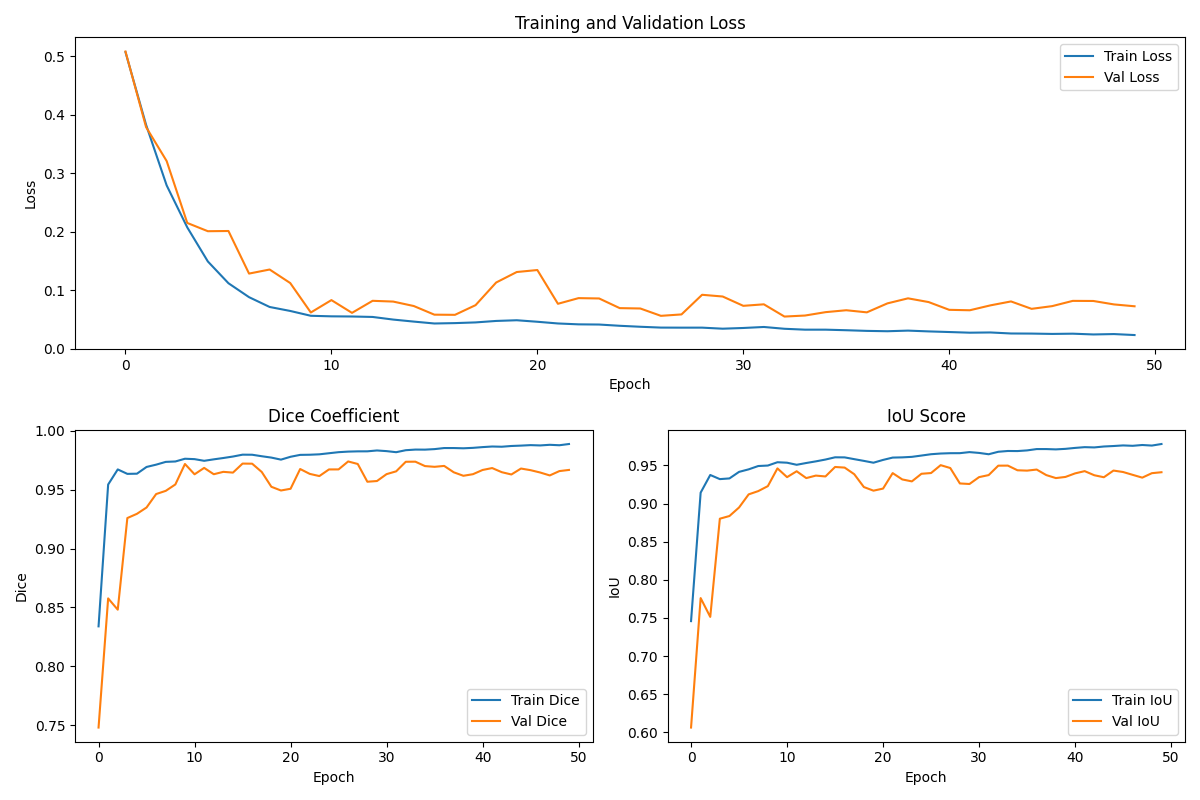

# Evaluated_results

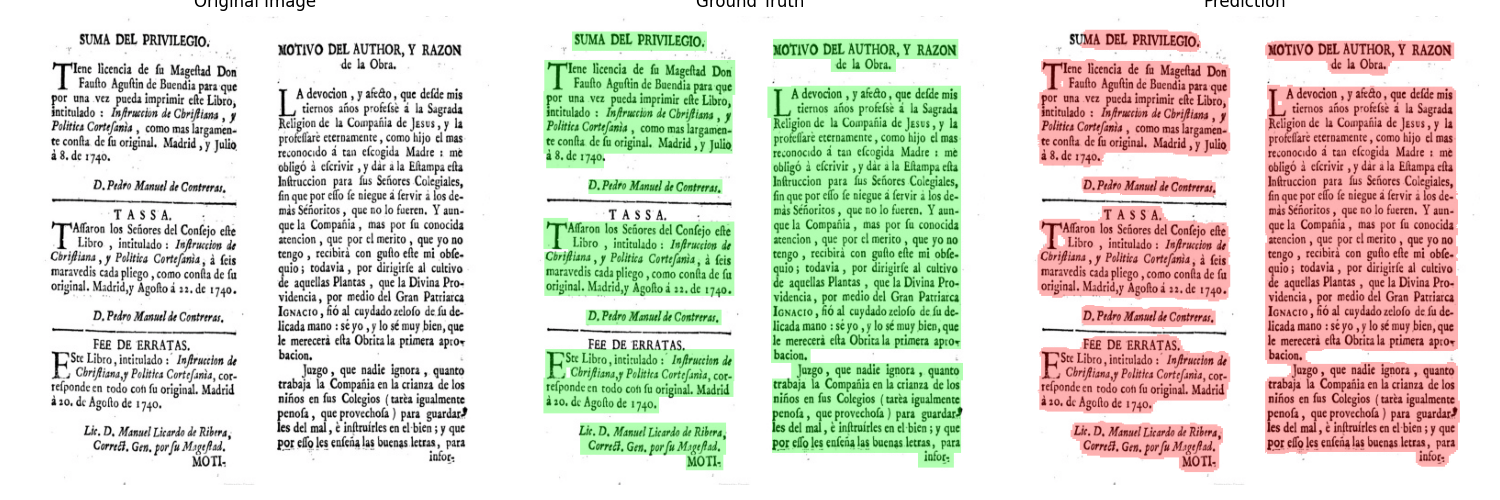
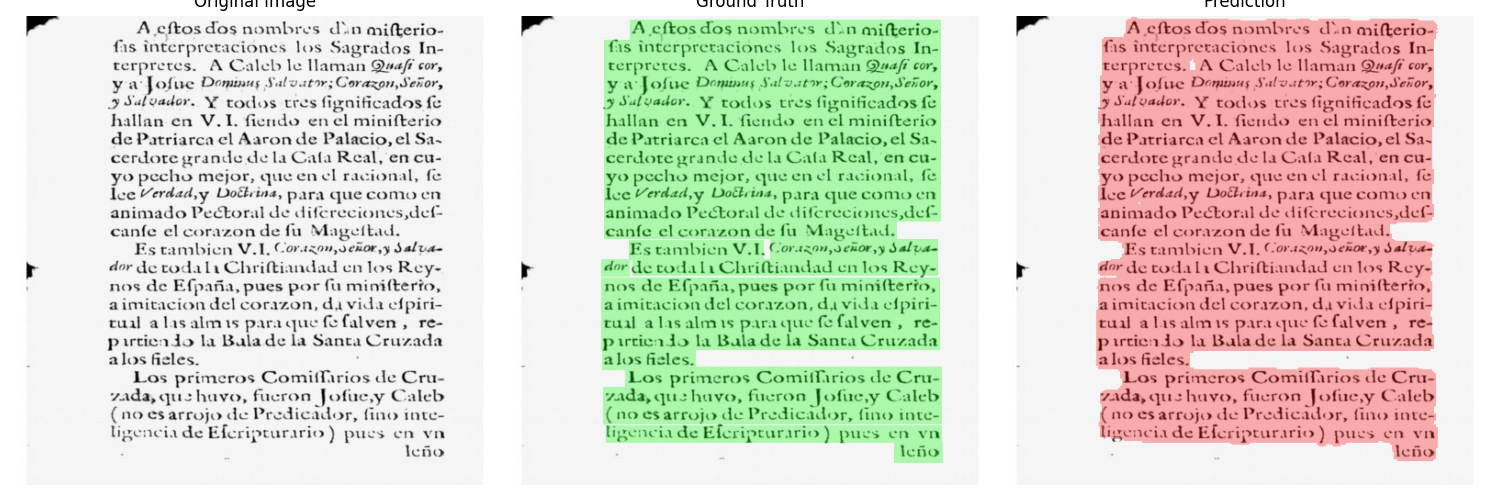

# prediction
using latest/best model to predict on a custom dataset

In [4]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from pdf2image import convert_from_path
import sys
import cv2

# from layout_recognition.model_script import get_model
# from layout_recognition.evaluate_script import load_model

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def create_pyramid(image, min_size=512, scale_factor=0.75):
    """
    For image resizing

    """
    # Convert PIL to numpy for OpenCV
    img_np = np.array(image)
    
    # Create pyramid
    pyramid = []
    current_img = img_np.copy()
    pyramid.append(Image.fromarray(current_img))
    while True:
        height, width = current_img.shape[:2]
        new_height = int(height * scale_factor)
        new_width = int(width * scale_factor)
        
        if new_height < min_size or new_width < min_size:
            break
        current_img = cv2.resize(current_img, (new_width, new_height), 
                                interpolation=cv2.INTER_AREA)
        pyramid.append(Image.fromarray(current_img))
    
    return pyramid
def load_model(model_path, model_name='cnn_rnn_model', device='cpu'):
    """
    Load a trained model.
    
    """    
    print(f"Loading model from: {model_path}")
    print(f"Model name: {model_name}")

    model = get_model(model_name)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    return model
def predict_layout(pdf_path, model_path=None, model_name='cnn_rnn_model', output_dir='results/predictions'):

    os.makedirs(output_dir, exist_ok=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    print(f"Converting PDF to image: {pdf_path}")
    images = convert_from_path(pdf_path, dpi=150, poppler_path = r"C:\Users\pwal9\Downloads\Release-24.08.0-0 (1)\poppler-24.08.0\Library\bin")

    if model_path is None:
        model_dir = os.path.join('models', 'layout')
        model_paths = [os.path.join(model_dir, d, 'best_model.pth') for d in os.listdir(model_dir) 
                      if os.path.isdir(os.path.join(model_dir, d))]
        model_paths = [p for p in model_paths if os.path.exists(p)]
        
        if not model_paths:
            print("No trained model found. Please train a model first.")
            return
        
        model_path = sorted(model_paths, key=lambda p: os.path.getmtime(p))[-1]
    
    print(f"Using model: {model_path}")

    model = load_model(model_path, model_name, device)
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    for i, img in enumerate(images):
        print(f"Processing page {i+1}/{len(images)}")
        pyramid = create_pyramid(img)
        print(f"Created pyramid with {len(pyramid)} levels")

        combined_pred = np.zeros((512, 512), dtype=np.float32)

        for level, pyramid_img in enumerate(pyramid):
            img_tensor = transform(pyramid_img).unsqueeze(0).to(device)
            
            with torch.no_grad():
                output = model(img_tensor)
            level_pred = output.cpu().squeeze().numpy()
            if level_pred.shape != (512, 512):
                level_pred = cv2.resize(level_pred, (512, 512))
            
            weight = 1.0 / (level + 1)
            combined_pred += level_pred * weight
    
        combined_pred = combined_pred / sum(1.0 / (l + 1) for l in range(len(pyramid)))
        pred_binary = (combined_pred > 0.5).astype(np.float32)
        
        img_np = np.array(img.resize((512, 512)))
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(img_np)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        overlay = img_np.copy()
        red_mask = np.zeros_like(overlay)
        red_mask[:, :, 0] = 255
        
        alpha = 0.3
        mask_bool = pred_binary > 0.5
        
        if mask_bool.shape != overlay.shape[:2]:
            mask_bool_resized = np.zeros(overlay.shape[:2], dtype=bool)
            h, w = min(mask_bool.shape[0], overlay.shape[0]), min(mask_bool.shape[1], overlay.shape[1])
            mask_bool_resized[:h, :w] = mask_bool[:h, :w]
            mask_bool = mask_bool_resized
        
        for c in range(3):
            overlay_channel = overlay[:, :, c]
            red_channel = red_mask[:, :, c]
            overlay_channel[mask_bool] = (1-alpha) * overlay_channel[mask_bool] + alpha * red_channel[mask_bool]
            overlay[:, :, c] = overlay_channel
        
        axes[1].imshow(overlay)
        axes[1].set_title('Predicted Text Regions')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'prediction_page_{i+1}.png'))
        plt.close()
    
    print(f"Predictions saved to {output_dir}")

if __name__ == "__main__":
    pdf_path = "sample.pdf"
    predict_layout(pdf_path)

Using device: cuda
Converting PDF to image: sample.pdf
Using model: models\layout\CNN_RNN_Model_20250306_201730\best_model.pth
Loading model from: models\layout\CNN_RNN_Model_20250306_201730\best_model.pth
Model name: cnn_rnn_model
Processing page 1/9
Created pyramid with 7 levels
Processing page 2/9
Created pyramid with 7 levels
Processing page 3/9
Created pyramid with 7 levels
Processing page 4/9
Created pyramid with 7 levels
Processing page 5/9
Created pyramid with 7 levels
Processing page 6/9
Created pyramid with 7 levels
Processing page 7/9
Created pyramid with 7 levels
Processing page 8/9
Created pyramid with 7 levels
Processing page 9/9
Created pyramid with 7 levels
Predictions saved to results/predictions


# random_data
Testing the model on a random historical pdf taken from the internet !

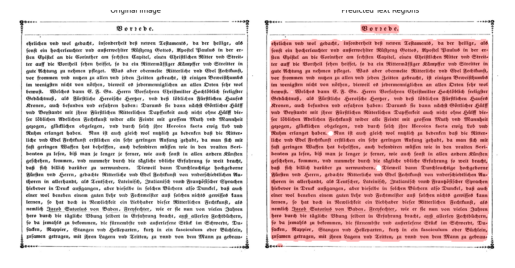

In [3]:
import cv2
import matplotlib.pyplot as plt

#Read the image using OpenCV (cv2)
img = cv2.imread("results/predictions/prediction_page_4.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

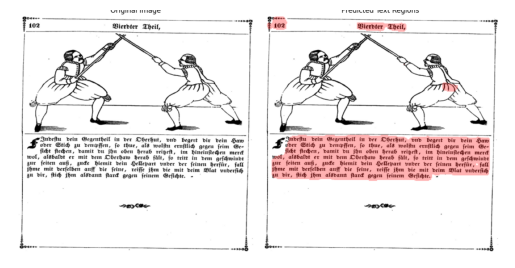

In [4]:
img = cv2.imread("results/predictions/prediction_page_9.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.show()